In [2]:
from ultralytics import YOLO

In [10]:
model = YOLO("runs/detect/nano_real/weights/best.pt")
results = model("C:/Users/jotir/Downloads/train-1/publaynet/train/PMC517497_00004.jpg", save=False, conf = .8) 
#results = model("C:/Users/jotir/OneDrive/Pictures/Screenshots/12.png", save=False, conf = .1)
#results = model("reserchpaper/papers/6.png", save=False, conf = .1)
#results = model("C:/Users/jotir/Downloads/train-1/chart.png", save=False, conf = .1)
for result in results:
    result.show()


image 1/1 C:\Users\jotir\Downloads\train-1\publaynet\train\PMC517497_00004.jpg: 640x512 2 images, 2 texts, 89.7ms
Speed: 4.9ms preprocess, 89.7ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 512)


In [ ]:
#T PMC1184095_00003 PMC519031_00006 PMC514717_00006 PMC509421_00003 PMC514891_00000 PMC514891_00003 PMC514898_00000 PMC514498_00002 PMC514603_00000 PMC514606_00003 PMC514606_00005 
#TI PMC514614_00002 PMC517497_00004 PMC517509_00002 PMC520831_00001 PMC521695_00006

#Miss
#TG PMC520833_00004 PMC522824_00005 PMC544845_00005 PMC548294_00005 PMC555764_00005 PMC1079928_00005


c:\Users\jotir\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


c:\Users\jotir\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jotir\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 4920/4920 [09:18<00:00,  8.80it/s]


Total samples: 98192
Label distribution:
Counter({'text_synth': 59434, 'image_synth': 37035, 'text_real': 1483, 'image_real': 240})
Running t-SNE...


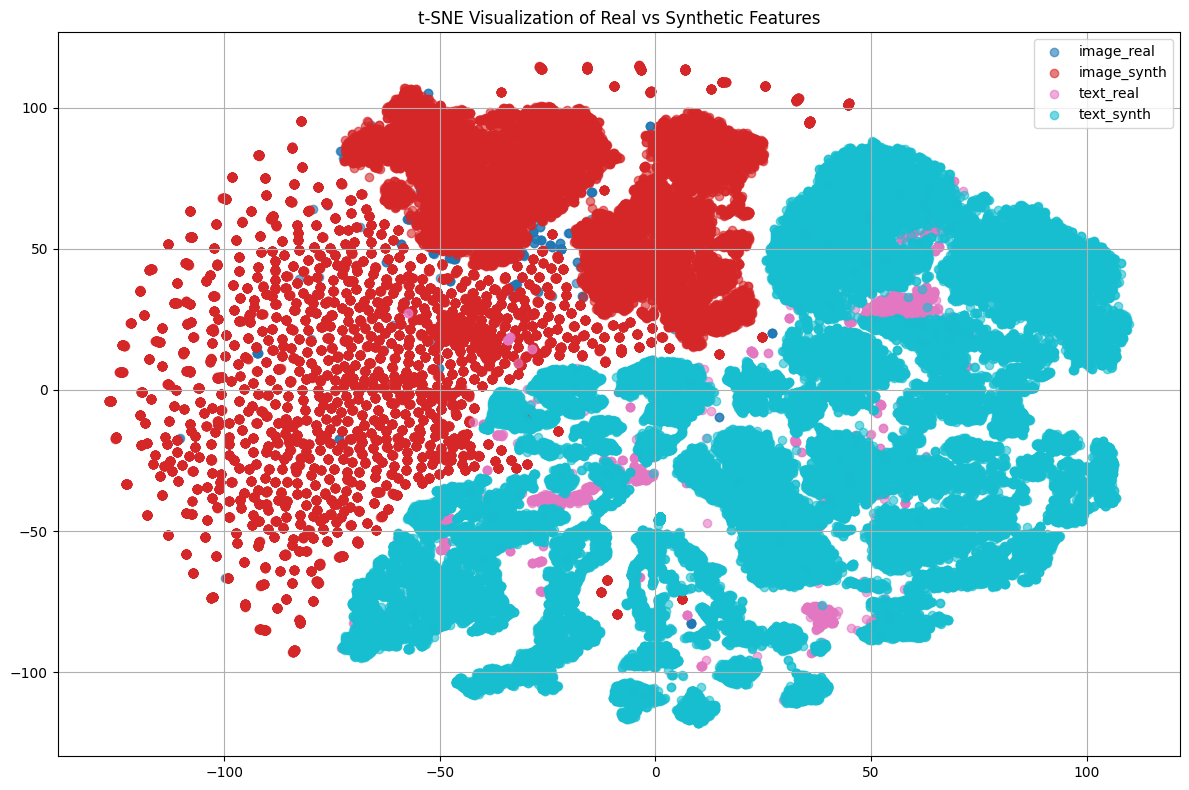

In [ ]:
import os
import torch
import torchvision.transforms as T
from torchvision.models import resnet18
from PIL import Image
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


real_img_dir = r"C:\Users\jotir\Downloads\Document\valid\images"
real_lbl_dir = r"C:\Users\jotir\Downloads\Document\valid\labels"

synth_img_dir = r"C:\Users\jotir\OneDrive\Desktop\AWS\college_project\atraining\train\images"
synth_lbl_dir = r"C:\Users\jotir\OneDrive\Desktop\AWS\college_project\atraining\train\labels"


class_map = { '0': 'image', '1': 'text'}

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

model = resnet18(pretrained=True)
model.fc = torch.nn.Identity()
model.to(device)  
model.eval()


def extract_crops_and_features(img_path, lbl_path, domain):
    features = []
    labels = []
    try:
        img = Image.open(img_path).convert("RGB")
        img_w, img_h = img.size
        with open(lbl_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls_id, cx, cy, w, h = map(float, parts)
                cls_id = int(cls_id)
                label_name = class_map[str(cls_id)]
                label = f"{label_name}_{domain}"

                
                x_center, y_center = cx * img_w, cy * img_h
                box_w, box_h = w * img_w, h * img_h
                x1 = int(max(x_center - box_w / 2, 0))
                y1 = int(max(y_center - box_h / 2, 0))
                x2 = int(min(x_center + box_w / 2, img_w))
                y2 = int(min(y_center + box_h / 2, img_h))

                crop = img.crop((x1, y1, x2, y2))
                crop_tensor = transform(crop).unsqueeze(0).to(device)

                with torch.no_grad():
                    feat = model(crop_tensor).squeeze().cpu().numpy()
                features.append(feat)
                labels.append(label)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
    return features, labels


def process_folder(img_dir, lbl_dir, domain):
    all_feats = []
    all_labels = []
    for fname in tqdm(os.listdir(img_dir)):
        if not fname.endswith((".jpg", ".png")):
            continue
        name = os.path.splitext(fname)[0]
        img_path = os.path.join(img_dir, fname)
        lbl_path = os.path.join(lbl_dir, name + ".txt")
        if not os.path.exists(lbl_path):
            continue
        feats, labels = extract_crops_and_features(img_path, lbl_path, domain)
        all_feats.extend(feats)
        all_labels.extend(labels)
    return all_feats, all_labels


real_feats, real_labels = process_folder(real_img_dir, real_lbl_dir, "real")
synth_feats, synth_labels = process_folder(synth_img_dir, synth_lbl_dir, "synth")

X = np.array(real_feats + synth_feats)
y = np.array(real_labels + synth_labels)

print(f"Total samples: {len(X)}")
print("Label distribution:")
from collections import Counter
print(Counter(y))


print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X)


plt.figure(figsize=(12, 8))
unique_labels = sorted(set(y))
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
for i, label in enumerate(unique_labels):
    idxs = np.where(y == label)
    plt.scatter(X_2d[idxs, 0], X_2d[idxs, 1], label=label, color=colors[i], alpha=0.6)

plt.legend()
plt.title("t-SNE Visualization of Real vs Synthetic Features")
plt.grid(True)
plt.tight_layout()
plt.show()


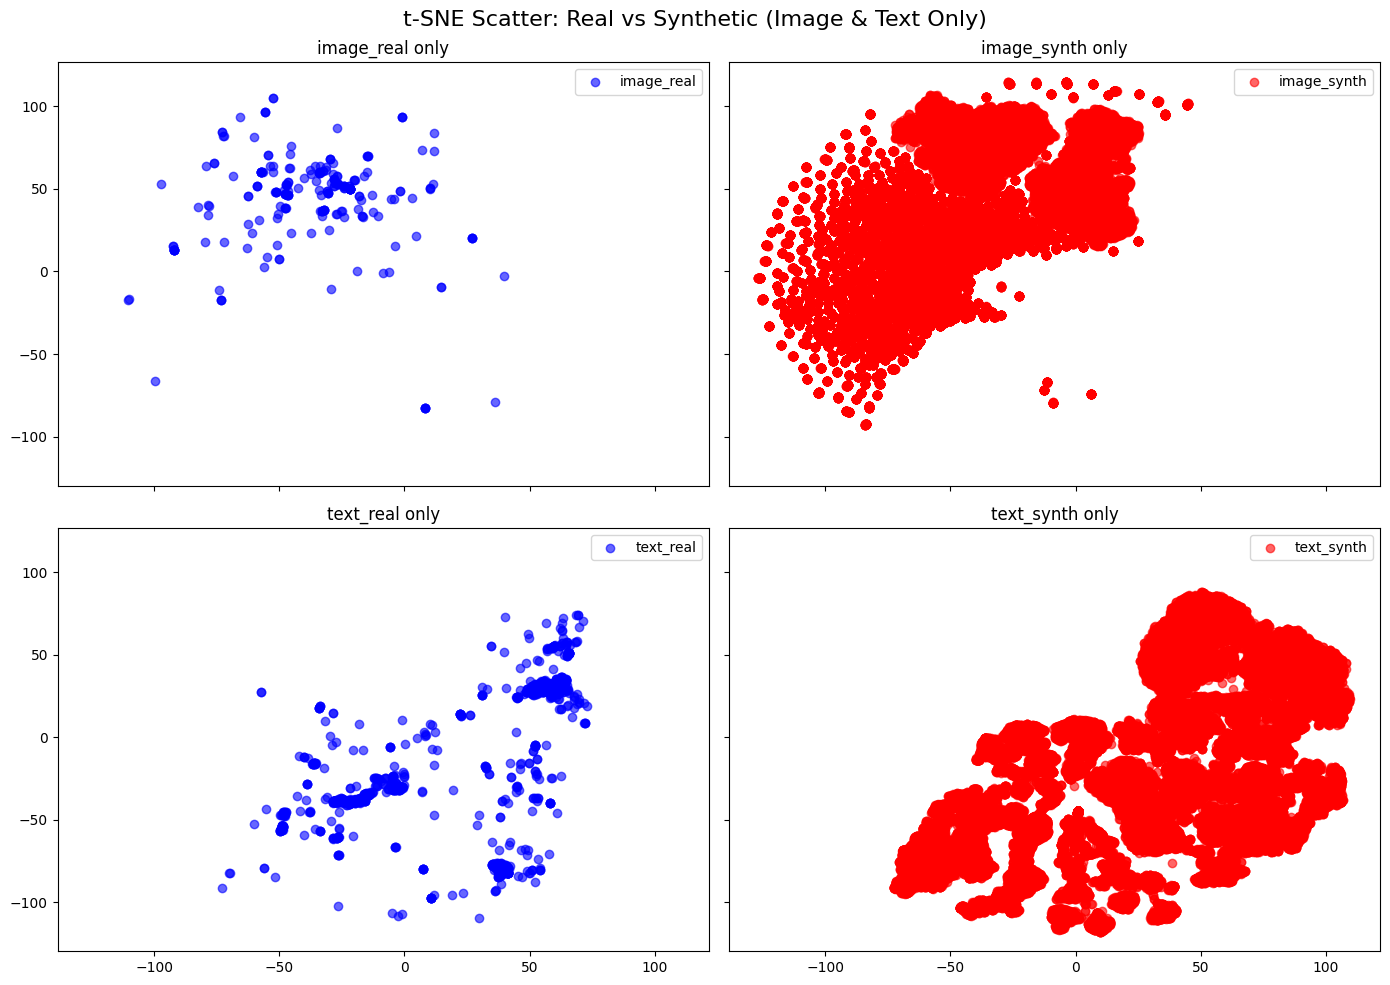

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

class_domain_pairs = [
    ("image_real", "image_synth"),
    ("text_real", "text_synth")
]

for row, (label_real, label_synth) in enumerate(class_domain_pairs):
    
    idx_real = np.where(y == label_real)[0]
    axs[row, 0].scatter(X_2d[idx_real, 0], X_2d[idx_real, 1],
                        alpha=0.6, c="blue", label=label_real)
    axs[row, 0].legend()
    axs[row, 0].set_title(f"{label_real} only")

    
    idx_synth = np.where(y == label_synth)[0]
    axs[row, 1].scatter(X_2d[idx_synth, 0], X_2d[idx_synth, 1],
                        alpha=0.6, c="red", label=label_synth)
    axs[row, 1].legend()
    axs[row, 1].set_title(f"{label_synth} only")

plt.suptitle("t-SNE Scatter: Real vs Synthetic (Image & Text Only)", fontsize=16)
plt.tight_layout()
plt.show()


Evaluating model: runs/detect/train12/weights/last.pt
WARNING  'save_hybrid=True' will append ground truth to predictions for autolabelling.
WARNING  'save_hybrid=True' will cause incorrect mAP.

Ultralytics 8.3.100  Python-3.11.6 torch-2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv12s summary (fused): 159 layers, 9,231,654 parameters, 0 gradients, 21.2 GFLOPs


val: Scanning C:\Users\jotir\Downloads\train-2\labels.cache... 598 images, 0 backgrounds, 0 corrupt: 100%|██████████| 598/598 [00:00<?, ?it/s]
c:\Users\jotir\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:12<00:00,  3.02it/s]


                   all        598       5152          1          1      0.995      0.995
                 image        258        307          1          1      0.995      0.995
                  text        598       4845          1          1      0.995      0.995
Speed: 0.8ms preprocess, 7.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Saving runs\detect\val10\predictions.json...
Results saved to runs\detect\val10

---- RESULTS ----
mAP50: 0.9950
mAP50-95: 0.9950
Precision: 1.0000
Recall: 1.0000


In [1]:
import os
import json
import shutil
from PIL import Image
from tqdm import tqdm

# ---- CONFIG ----
COCO_JSON_PATH = r"C:\Users\jotir\Downloads\labels\publaynet\train.json"
IMAGES_SRC_DIR = r"C:\Users\jotir\Downloads\train-2\publaynet\train"
IMAGES_DST_DIR = r"C:\Users\jotir\Downloads\train-2\images"
LABELS_DST_DIR = r"C:\Users\jotir\Downloads\train-2\labels"              # Where YOLO txt labels will go

os.makedirs(IMAGES_DST_DIR, exist_ok=True)
os.makedirs(LABELS_DST_DIR, exist_ok=True)

# ---- YOLO Class Mapping ----
CATEGORY_TO_YOLO = {
    1: 0,  # text
    2: 0,  # title
    3: 1,  # list
    4: 1,  # table
    5: 1,  # figure
}

# ---- Load Annotations ----
with open(COCO_JSON_PATH, 'r') as f:
    data = json.load(f)

images_info = {img['id']: img for img in data['images']}
annotations = data['annotations']

# ---- Group annotations by image_id ----
ann_by_img = {}
for ann in annotations:
    img_id = ann['image_id']
    if img_id not in ann_by_img:
        ann_by_img[img_id] = []
    ann_by_img[img_id].append(ann)

# ---- Process only available images ----
available_files = set(os.listdir(IMAGES_SRC_DIR))
processed = 0
skipped = 0

for img_id, img_info in tqdm(images_info.items(), desc="Processing images"):
    file_name = img_info['file_name']
    width, height = img_info['width'], img_info['height']
    
    if file_name not in available_files:
        skipped += 1
        continue  # skip missing image

    src_path = os.path.join(IMAGES_SRC_DIR, file_name)
    dst_path = os.path.join(IMAGES_DST_DIR, file_name)
    shutil.copyfile(src_path, dst_path)

    yolo_lines = []
    for ann in ann_by_img.get(img_id, []):
        cat_id = ann['category_id']
        if cat_id not in CATEGORY_TO_YOLO:
            continue
        
        yolo_class = CATEGORY_TO_YOLO[cat_id]
        x, y, w, h = ann['bbox']
        
        # COCO to YOLO format
        x_center = (x + w / 2) / width
        y_center = (y + h / 2) / height
        w /= width
        h /= height

        yolo_lines.append(f"{yolo_class} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

    # Save to label file if there are annotations
    if yolo_lines:
        label_path = os.path.join(LABELS_DST_DIR, os.path.splitext(file_name)[0] + '.txt')
        with open(label_path, 'w') as f:
            f.write('\n'.join(yolo_lines))
        processed += 1
    else:
        # Optionally remove copied image if no annotations exist
        os.remove(dst_path)

print(f"\n✅ Done: {processed} images processed with annotations.")
print(f"⏭️ Skipped {skipped} missing images.")


Processing images: 100%|██████████| 335703/335703 [09:24<00:00, 594.68it/s] 


✅ Done: 47958 images processed with annotations.
⏭️ Skipped 287745 missing images.


In [2]:
import os
import json
import shutil
from PIL import Image
from tqdm import tqdm
from collections import defaultdict

# ---- CONFIG ----
COCO_JSON_PATH = r"C:\Users\jotir\Downloads\labels\publaynet\train.json"
IMAGES_SRC_DIR = r"C:\Users\jotir\Downloads\train-2\publaynet\train"
IMAGES_DST_DIR = r"C:\Users\jotir\Downloads\train-2\images"
LABELS_DST_DIR = r"C:\Users\jotir\Downloads\train-2\labels"

# ---- CLASS MAPPING ----
COCO_TO_YOLO = {
    "text": 1,     # mapped to class 1
    "title": 1,    # mapped to class 1
    "figure": 0,   # mapped to class 0
    "list": -1,    # ignored
    "table": -1    # ignored
}

# ---- Ensure output dirs exist ----
os.makedirs(IMAGES_DST_DIR, exist_ok=True)
os.makedirs(LABELS_DST_DIR, exist_ok=True)

# ---- Load COCO ----
with open(COCO_JSON_PATH, "r") as f:
    coco = json.load(f)

id_to_name = {cat["id"]: cat["name"] for cat in coco["categories"]}
annots_by_image = defaultdict(list)
for ann in coco["annotations"]:
    annots_by_image[ann["image_id"]].append(ann)

skipped_images = 0
converted = 0

# ---- Main Loop ----
for img in tqdm(coco["images"]):
    img_id = img["id"]
    img_name = img["file_name"]
    img_path = os.path.join(IMAGES_SRC_DIR, img_name)

    if not os.path.exists(img_path):
        skipped_images += 1
        continue

    anns = annots_by_image.get(img_id, [])
    label_lines = []
    has_invalid = False

    for ann in anns:
        cat_id = ann["category_id"]
        cat_name = id_to_name[cat_id]
        yolo_class = COCO_TO_YOLO.get(cat_name, -1)

        if yolo_class == -1:
            has_invalid = True
            break

        x, y, w, h = ann["bbox"]

        try:
            with Image.open(img_path) as im:
                img_w, img_h = im.size
        except:
            continue

        x_center = (x + w / 2) / img_w
        y_center = (y + h / 2) / img_h
        w_norm = w / img_w
        h_norm = h / img_h

        label_lines.append(f"{yolo_class} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")

    if has_invalid or len(label_lines) == 0:
        continue

    # Save image and label
    shutil.copy(img_path, os.path.join(IMAGES_DST_DIR, img_name))
    label_path = os.path.join(LABELS_DST_DIR, os.path.splitext(img_name)[0] + ".txt")
    with open(label_path, "w") as f:
        f.write("\n".join(label_lines))

    converted += 1

print(f"\n✅ Done! Converted {converted} images (text=1, figure=0), skipped {skipped_images} missing.")


100%|██████████| 335703/335703 [10:26<00:00, 536.14it/s]



✅ Done! Converted 29103 images (text=1, figure=0), skipped 287745 missing.


In [5]:
from collections import Counter

def count_yolo_labels(labels_folder):
    class_counts = Counter()
    
    for label_file in os.listdir(labels_folder):
        if label_file.endswith('.txt'):
            with open(os.path.join(labels_folder, label_file), 'r') as f:
                for line in f:
                    line = line.strip()
                    if line:
                        class_id = int(line.split()[0])
                        class_counts[class_id] += 1

    for class_id, count in sorted(class_counts.items()):
        print(f"Class {class_id}: {count}")
    return class_counts

# Usage example:
labels_folder = r'C:\Users\jotir\Downloads\train-2\labels'  # Replace with your actual folder path
background, text = count_yolo_labels(labels_folder)

Class 0: 12202
Class 1: 259146



📊 Class-wise Evaluation:

Class: IMAGE
True Positives (TP): 191
False Positives (FP): 45
False Negatives (FN): 116
Background Predictions: 45
Precision: 0.8093
Recall: 0.6221

Class: TEXT
True Positives (TP): 2455
False Positives (FP): 416
False Negatives (FN): 2390
Background Predictions: 416
Precision: 0.8551
Recall: 0.5067


In [53]:
import os
import shutil

# Paths
images_folder = r"C:\Users\jotir\Downloads\train-2\images"    # Replace with your image folder
labels_folder = r"C:\Users\jotir\Downloads\train-2\labels2"      # Replace with your label folder
output_labels_folder = r"C:\Users\jotir\Downloads\train-2\labels"

# Create output folder if not exists
os.makedirs(output_labels_folder, exist_ok=True)

# Get all image filenames (without extension)
image_basenames = {os.path.splitext(f)[0] for f in os.listdir(images_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))}

# Copy matching label files
for label_file in os.listdir(labels_folder):
    name, ext = os.path.splitext(label_file)
    if ext == ".txt" and name in image_basenames:
        src = os.path.join(labels_folder, label_file)
        dst = os.path.join(output_labels_folder, label_file)
        shutil.copyfile(src, dst)

print("✅ Done! Copied all labels that have corresponding images.")


✅ Done! Copied all labels that have corresponding images.


In [5]:
import os
import shutil

# ==== CONFIG ====
images_folder = r"C:\Users\jotir\Downloads\train-2\images"
labels_folder = r"C:\Users\jotir\Downloads\train-2\labels"

# ==== RENAME ====
image_files = sorted([f for f in os.listdir(images_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])

for idx, image_file in enumerate(image_files, start=1):
    name, ext = os.path.splitext(image_file)
    new_image_name = f"{idx}{ext}"
    new_label_name = f"{idx}.txt"

    # Rename image
    old_image_path = os.path.join(images_folder, image_file)
    new_image_path = os.path.join(images_folder, new_image_name)
    os.rename(old_image_path, new_image_path)

    # Rename corresponding label if exists
    old_label_path = os.path.join(labels_folder, f"{name}.txt")
    new_label_path = os.path.join(labels_folder, new_label_name)
    if os.path.exists(old_label_path):
        os.rename(old_label_path, new_label_path)

print("✅ All images and corresponding labels have been renamed.")


✅ All images and corresponding labels have been renamed.


In [ ]:
import os

# Specify the path to the folder
folder_path = r"C:\Users\jotir\Downloads\train-2\images2"

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    # Check if filename ends with '00000' before the extension
    name, ext = os.path.splitext(filename)
    if name.endswith('00000') and ext.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.gif']:
        file_path = os.path.join(folder_path, filename)
        os.remove(file_path)
        print(f'Deleted {filename}')
